# World Immunity


## Data Load

In [1]:
# Load Libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
import calendar
import scipy
import statsmodels as sms
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Read Data
df = pd.read_csv("country_vaccinations.csv")

In [3]:
# Look at the data
df.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Albania,ALB,2021-01-10,0.0,0.0,NaN,NaN,NaN,0.00,0.00,NaN,NaN,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
1,Albania,ALB,2021-01-11,NaN,NaN,NaN,NaN,64.0,NaN,NaN,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
2,Albania,ALB,2021-01-12,128.0,128.0,NaN,NaN,64.0,0.00,0.00,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
3,Albania,ALB,2021-01-13,188.0,188.0,NaN,60.0,63.0,0.01,0.01,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
4,Albania,ALB,2021-01-14,266.0,266.0,NaN,78.0,66.0,0.01,0.01,NaN,23.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...


Dimension of data (6325, 15)

Null values:
 country                                   0
iso_code                                364
date                                      0
total_vaccinations                     2266
people_vaccinated                      2713
people_fully_vaccinated                3869
daily_vaccinations_raw                 2898
daily_vaccinations                      194
total_vaccinations_per_hundred         2266
people_vaccinated_per_hundred          2713
people_fully_vaccinated_per_hundred    3869
daily_vaccinations_per_million          194
vaccines                                  0
source_name                               0
source_website                            0
dtype: int64

Correlation Plot


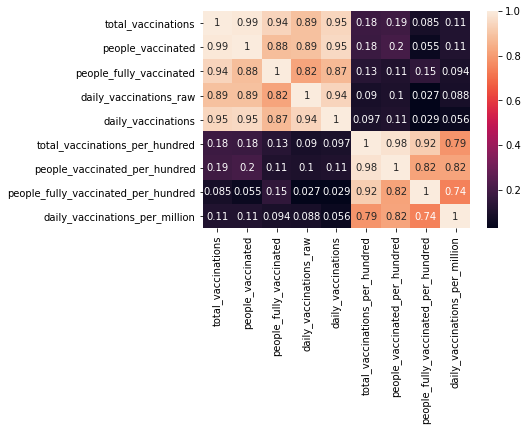

In [4]:
# Data dimension
print("Dimension of data", df.shape)

# Null elements
print("\nNull values:\n", df.isna().sum())

# Multi Correlation analysis
print("\nCorrelation Plot")
sns.heatmap(df.corr(), annot=True)

## Column Analysis
1. **iso_code** can be dropped, as it directly correlates with country name.
2. **total_vaccinations** null values can be dropped, as without this, analysis cannot proceed. 
3. total_vaccinations and **people_vaccinated** are highly correlated. Hence total_vaccinations can be dropped (it has more null values than people_vaccinated)
4. Similarly with their  **per_hundred** columns.
5. **daily_vaccinated** is also highly correlated with people_vaccinated. That can be dropped.
6. **vaccines**, **source_name** and **source_website** is unimportant for current analysis objective.
7.  **date** needs to be converted to datetime format.


Dimension of data (6325, 8)

Null values:
 country                                False
date                                   False
people_vaccinated                      False
people_fully_vaccinated                False
daily_vaccinations_raw                 False
people_vaccinated_per_hundred          False
people_fully_vaccinated_per_hundred    False
daily_vaccinations_per_million         False
dtype: bool

Correlation Plot


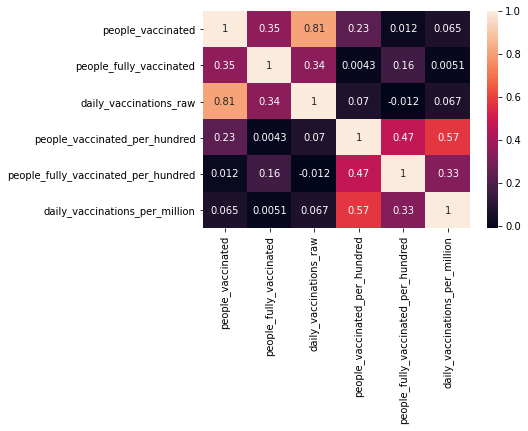

In [5]:
# Choose the necessary columns
df_clean = df[['country', 'date', 'people_vaccinated', 'people_fully_vaccinated',
       'daily_vaccinations_raw', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'daily_vaccinations_per_million']]

# Forward fill non-null values (Assumption: The number hasn't changed)       
df_clean.fillna(method='ffill', inplace=True)

# Replace with 0, the values not yet filled in previous step (Assumption: Starting with 0)
df_clean.fillna(value=0, inplace=True)

# Date conversion
df_clean["date"] = pd.to_datetime(df_clean["date"], format = '%Y-%m-%d')

# Verify
print("Dimension of data", df_clean.shape)
print("\nNull values:\n", df_clean.isna().any())
print("\nCorrelation Plot")
sns.heatmap(df_clean.corr(), annot=True)

## EDA

In [6]:
#  Lets look at current scenario
df_latest = df_clean.groupby('country', as_index = True).max()

# Most vaccinated countries
df_latest_most_vaccinated = df_latest.sort_values(by='people_vaccinated', ascending = False)
df_latest_most_vaccinated.head()

,date,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
country,,,,,,,
United States,2021-03-14,69784210.0,37459269.0,4575496.0,20.87,11.20,7600.0
India,2021-03-14,24452385.0,5455653.0,2053537.0,1.77,3.76,2977.0
Indonesia,2021-03-14,24452385.0,5455653.0,363003.0,1.77,0.53,923.0
United Kingdom,2021-03-13,24196211.0,2187849.0,609010.0,35.64,22.12,6558.0
Estonia,2021-03-14,20568821.0,1115066.0,496272.0,36.54,3.97,5128.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

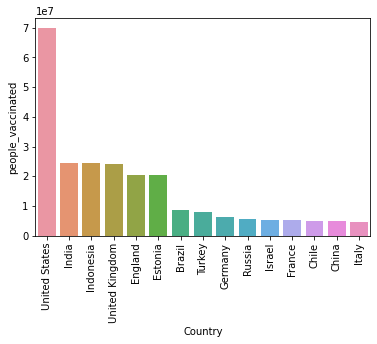

In [7]:
# Graphical representation of above 
ax = sns.barplot(x = df_latest['people_vaccinated'].sort_values(ascending = False).head(15).index,
                 y = df_latest['people_vaccinated'].sort_values(ascending = False).head(15))
ax.set_xlabel('Country')
ax.set_ylabel('people_vaccinated')
plt.xticks(rotation = 90)

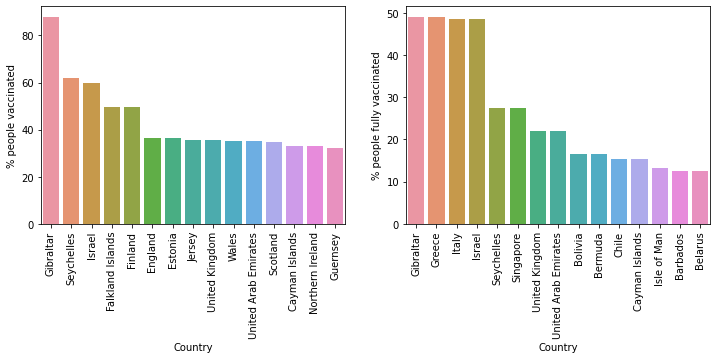

In [8]:
plt.figure(figsize = (12,4))

plt.subplot(121)
# Graphical representation of most % vaccinated 
ax = sns.barplot(x = df_latest['people_vaccinated_per_hundred'].sort_values(ascending = False).head(15).index,
                 y = df_latest['people_vaccinated_per_hundred'].sort_values(ascending = False).head(15))
ax.set_xlabel('Country')
ax.set_ylabel('% people vaccinated')
plt.xticks(rotation = 90)

plt.subplot(122)
# Graphical representation of most % fully vaccinated 
ax = sns.barplot(x = df_latest['people_fully_vaccinated_per_hundred'].sort_values(ascending = False).head(15).index,
                 y = df_latest['people_fully_vaccinated_per_hundred'].sort_values(ascending = False).head(15))
ax.set_xlabel('Country')
ax.set_ylabel('% people fully vaccinated')
plt.xticks(rotation = 90)

plt.show()

## India Data

In [9]:
india_data = df_clean[df_clean['country']=='India'][["date", "people_vaccinated", "people_vaccinated_per_hundred"]].reset_index(drop=True)
print(india_data.shape)
india_data.tail()

(59, 3)


,date,people_vaccinated,people_vaccinated_per_hundred
54,2021-03-10,21034481.0,1.52
55,2021-03-11,21435841.0,1.55
56,2021-03-12,23075504.0,1.67
57,2021-03-13,24307635.0,1.76
58,2021-03-14,24452385.0,1.77


In [10]:
india_data["people_vaccinated_per_hundred"].describe()

count    59.000000
mean      0.632034
std       0.482032
min       0.000000
25%       0.260000
50%       0.580000
75%       0.855000
max       1.770000
Name: people_vaccinated_per_hundred, dtype: float64

In [11]:
# verify people vaccinated per hundred
people_vaccinated_per_hundred_= india_data['people_vaccinated']/13800043.85
people_vaccinated_per_hundred_.describe()

# Data is clean and valid

count    59.000000
mean      0.632350
std       0.482472
min       0.000000
25%       0.262476
50%       0.582954
75%       0.856292
max       1.771906
Name: people_vaccinated, dtype: float64

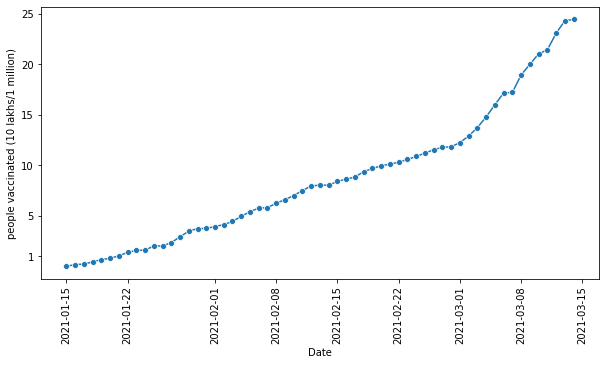

In [12]:
# Plot people vaccinated against time
plt.figure(figsize = (10, 5))
ax = sns.lineplot(x = india_data['date'], y = india_data['people_vaccinated'], marker='o')
ax.set_xlabel('Date')
plt.yticks(ticks = [1000000, 5000000, 10000000, 15000000, 20000000, 25000000], labels = [1, 5, 10, 15, 20, 25])
ax.set_ylabel('people vaccinated (10 lakhs/1 million)')
plt.xticks(rotation = 90)
plt.show()

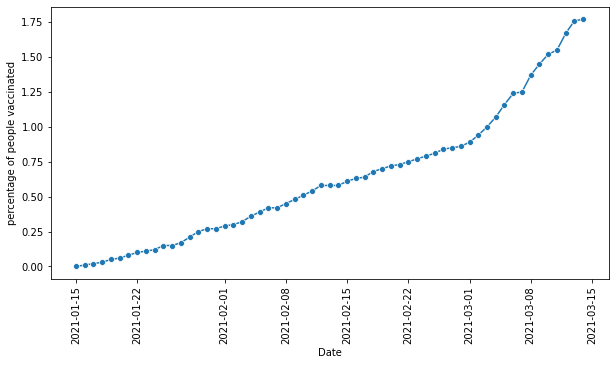

In [13]:
# Plot people vaccinated against time
plt.figure(figsize = (10, 5))
ax = sns.lineplot(x = india_data['date'], y = india_data['people_vaccinated_per_hundred'], marker='o')
ax.set_xlabel('Date')
ax.set_ylabel('percentage of people vaccinated')
plt.xticks(rotation = 90)
plt.show()

It would be difficult to predict when the country would reach immunity. Even for herd immunity (lower limit of 50%, even), the data collected until now is insufficient. Especialy with time series, it is considered wrong to predict into such futures. We shall create a model now, and run it at intervals in the future to get a better idea and train it for higher accuracy.

## Time Series Analysis

**Stationarity**

ACF and PACF plots drawn to check auto correlation and stationarity

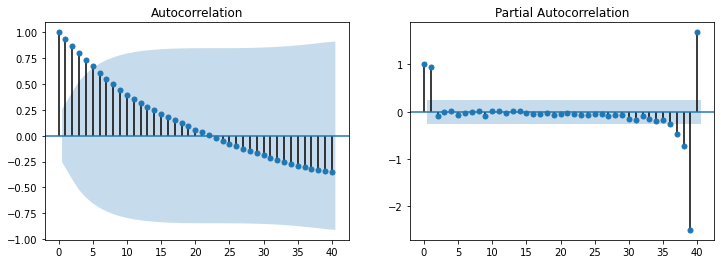

In [14]:
# Test for stationarity
plt.figure(figsize = (12,4))
plt.subplot(121)
plot_acf(india_data['people_vaccinated_per_hundred'], lags = 40, ax = plt.gca())
plt.subplot(122)
plot_pacf(india_data['people_vaccinated_per_hundred'], lags = 40, ax = plt.gca())
plt.show()

Data looks non-stationary. We shall perform Dicky-Fuler test to verify.

In [15]:
adfuller(india_data['people_vaccinated_per_hundred'])

(1.7006001016935044,
 0.9981300799468383,
 9,
 49,
 {'1%': -3.5714715250448363,
  '10%': -2.5993358475635153,
  '5%': -2.922629480573571},
 -219.6676968475237)

p-value is 0.99. Data is non-stationary.

Hence we shall consider first difference 

In [16]:
india_data['diff1'] = india_data['people_vaccinated_per_hundred'].diff(1)
india_data['diff1'] = india_data['diff1'].fillna(india_data['diff1'].mean())

In [17]:
adfuller(india_data.diff1)

(-0.9474234672084615,
 0.7719544959100899,
 8,
 50,
 {'1%': -3.568485864, '10%': -2.5986616, '5%': -2.92135992},
 -218.59326002917697)

Data is still non stationary. We shall consider second difference.

In [18]:
india_data['diff2'] = india_data['diff1'].diff()
india_data['diff2'] = india_data['diff2'].fillna(india_data['diff2'].mean())

In [19]:
adfuller(india_data.diff2)

(-2.3124585615524134,
 0.16798131548697948,
 7,
 51,
 {'1%': -3.5656240522121956,
  '10%': -2.598014675124952,
  '5%': -2.920142229157715},
 -219.31859285160004)

Data is still non stationary. We shall consider third difference.

In [20]:
india_data['diff3'] = india_data['diff2'].diff()
india_data['diff3'] = india_data['diff3'].fillna(india_data['diff3'].mean())

In [21]:
adfuller(india_data.diff3)

(-7.4751616332494,
 4.935743034214185e-11,
 6,
 52,
 {'1%': -3.562878534649522,
  '10%': -2.597393446745562,
  '5%': -2.918973284023669},
 -215.7307316255642)

Data is now stationary. But after 3rd differencing, data isnt usually reliable. We shall plot ACF and PACF values and try running the model.

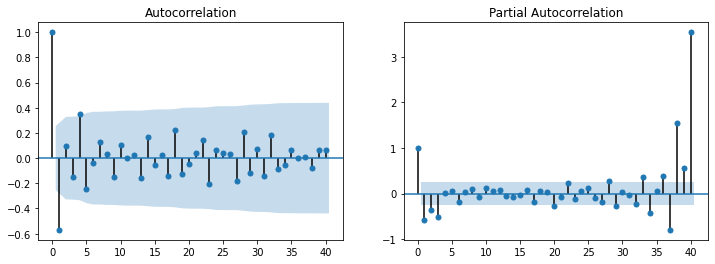

In [22]:
# Test for stationarity
plt.figure(figsize = (12,4))
plt.subplot(121)
plot_acf(india_data['diff3'], lags = 40, ax = plt.gca())
plt.subplot(122)
plot_pacf(india_data['diff3'], lags = 40, ax = plt.gca())
plt.show()

As seen from the graphs, the AR value (p) as well as MA value (q) is 1. 

## Forecast Model

In [23]:
train = india_data['people_vaccinated_per_hundred'][:50]
test = india_data['people_vaccinated_per_hundred'][50:]
model = ARIMA(train, order = (1,3,1))
model = model.fit()
pred = model.predict(50, 60, typ = 'levels')
print(pred)
plt.figure(figsize=(12,5), dpi=100)
ax = sns.lineplot(x=india_data['date'], y = pred, label='forecast')
sns.lineplot(x=india_data['date'], y = india_data['people_vaccinated_per_hundred'], label='actual', ax=ax)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

ValueError: ignored

The data and the library do not support working with data that is thrice differenced.

## World data analysis

In [24]:
# We're dealing now with World data
world_data = df_clean[['people_vaccinated', 'people_fully_vaccinated', 'date']].groupby('date', as_index = False).sum()
# daily_data['vac_test'] = daily_data['daily_vaccinations']
print("dimension:", world_data.shape)
world_data.head()

dimension: (92, 3)


,date,people_vaccinated,people_fully_vaccinated
0,2020-12-13,172930.0,42232946.0
1,2020-12-14,343589.0,42291363.0
2,2020-12-15,5181265.0,44768523.0
3,2020-12-16,5181265.0,44768523.0
4,2020-12-17,5181265.0,44768523.0


In [25]:
# Breaking down date for further EDA
world_data['year'] = world_data['date'].dt.year
world_data['month'] = world_data['date'].dt.month
world_data['month'] = world_data['month'].apply(lambda x: calendar.month_abbr[x])
world_data['day'] = world_data['date'].dt.day
world_data.head()

,date,people_vaccinated,people_fully_vaccinated,year,month,day
0,2020-12-13,172930.0,42232946.0,2020,Dec,13
1,2020-12-14,343589.0,42291363.0,2020,Dec,14
2,2020-12-15,5181265.0,44768523.0,2020,Dec,15
3,2020-12-16,5181265.0,44768523.0,2020,Dec,16
4,2020-12-17,5181265.0,44768523.0,2020,Dec,17


In [26]:
# People vaccinated each month - (March not yet completed)
world_data[['people_vaccinated', 'people_fully_vaccinated', 'month']].groupby('month', as_index = True).sum().head()

,people_vaccinated,people_fully_vaccinated
month,,
Dec,2.284845e+08,9.503879e+08
Feb,3.556723e+09,1.882608e+09
Jan,2.165191e+09,1.057338e+09
Mar,2.863801e+09,2.194229e+09


In [27]:
# General trend of people_vaccinated
world_data["people_vaccinated"].describe()

count    9.200000e+01
mean     9.580652e+07
std      6.606508e+07
min      1.729300e+05
25%      3.855895e+07
50%      8.927888e+07
75%      1.452745e+08
max      2.303041e+08
Name: people_vaccinated, dtype: float64

In [28]:
# Last few entries
world_data.tail(6)

# The data of the last 2 days seems incomplete. Hence we shall consider them as outliers and drop them from analysis
world_data.drop(world_data.tail(2).index, inplace = True) 

In [29]:
# Percentage of world vaccinated
# Current World population ~7900000000 (790 crore/7.9 billion)
world_data['people_vaccinated_per_hundred'] = world_data['people_vaccinated']/79000000
world_data.tail()

,date,people_vaccinated,people_fully_vaccinated,year,month,day,people_vaccinated_per_hundred
85,2021-03-08,213218094.0,167617856.0,2021,Mar,8,2.698963
86,2021-03-09,217665375.0,172324792.0,2021,Mar,9,2.755258
87,2021-03-10,224034590.0,172938711.0,2021,Mar,10,2.835881
88,2021-03-11,228504583.0,169723331.0,2021,Mar,11,2.892463
89,2021-03-12,230304092.0,170957513.0,2021,Mar,12,2.915242


In [30]:
world_data["people_vaccinated_per_hundred"].describe()

count    90.000000
mean      1.184637
std       0.821285
min       0.002189
25%       0.483201
50%       1.109730
75%       1.741920
max       2.915242
Name: people_vaccinated_per_hundred, dtype: float64

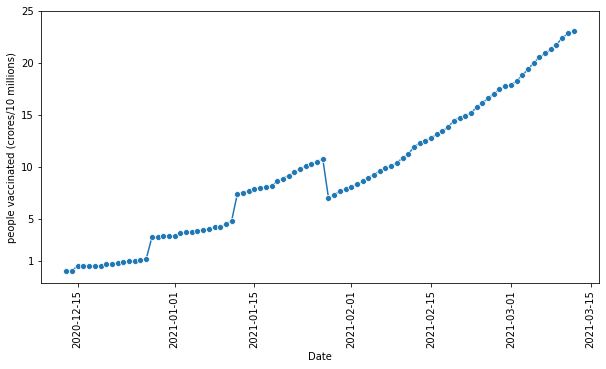

In [31]:
# Plot people vaccinated against time
plt.figure(figsize = (10, 5))
ax = sns.lineplot(x = world_data['date'], y = world_data['people_vaccinated'], marker='o')
ax.set_xlabel('Date')
plt.yticks(ticks = [10000000, 50000000, 100000000, 150000000, 200000000, 250000000], labels = [1, 5, 10, 15, 20, 25])
ax.set_ylabel('people vaccinated (crores/10 millions)')
plt.xticks(rotation = 90)
plt.show()

## Time Series Analysis

**Stationarity**

ACF and PACF plots drawn to check auto correlation and stationarity

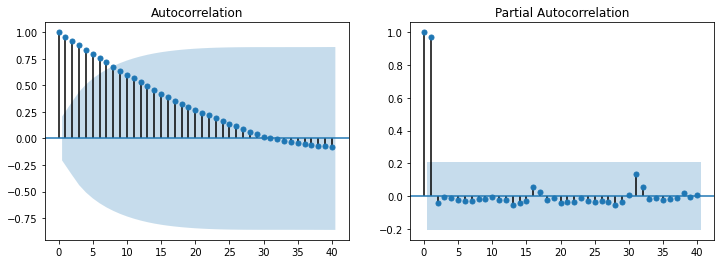

In [32]:
# Test for stationarity
plt.figure(figsize = (12,4))
plt.subplot(121)
plot_acf(world_data['people_vaccinated_per_hundred'], lags = 40, ax = plt.gca())
plt.subplot(122)
plot_pacf(world_data['people_vaccinated_per_hundred'], lags = 40, ax = plt.gca())
plt.show()

Data looks non-stationary. We shall perform Dicky-Fuler test to verify.

In [33]:
adfuller(world_data['people_vaccinated_per_hundred'])

(1.0984291374369506,
 0.9952031935733688,
 0,
 89,
 {'1%': -3.506057133647011,
  '10%': -2.5844100201994697,
  '5%': -2.8946066061911946},
 -177.08943910374603)

p-value is 0.99. Data is non-stationary.

Hence we shall consider first difference 

In [36]:
world_data['diff1'] = world_data['people_vaccinated_per_hundred'].diff(1)
world_data['diff1'] = world_data['diff1'].fillna(world_data['diff1'].mean())

In [37]:
adfuller(world_data.diff1)

(-9.22811773849943,
 1.7071819941937296e-15,
 0,
 89,
 {'1%': -3.506057133647011,
  '10%': -2.5844100201994697,
  '5%': -2.8946066061911946},
 -176.83631788612212)

Data is now stationary. Lets check the ACF and PACF graphs.

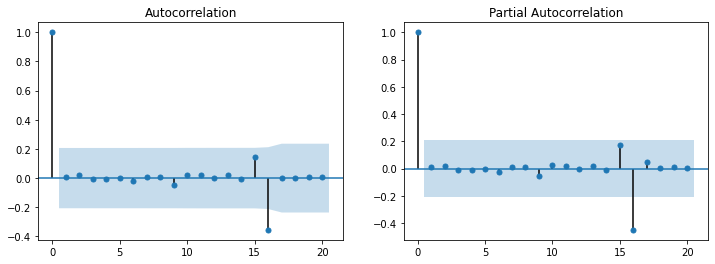

In [35]:
# Test for stationarity
plt.figure(figsize = (12,4))
plt.subplot(121)
plot_acf(world_data['diff1'], ax = plt.gca())
plt.subplot(122)
plot_pacf(world_data['diff1'], ax = plt.gca())
plt.show()

p and q values are indicated to be 16, which could be a result of noise, and is unreliable. 

## Inference

* India, while having the second largest population of people vaccinated, lags behind other countries when we consider our population.

* We have 59 data points available for India. India vaccinated is 1.75%. Even if we consider the lower limit of herd immunity to be 50%, we still have a long way to go. 

* Data collected until now is insufficient. Especially with time series, it is considered wrong to predict into such far futures. 

* This is further verified when the data became stationary after 3rd differencing, at which point, it is considered unreliable. 

* The story goes on similar lines for world immunity.  
We might be able to predict a few days into the future with a few more data points, but predicting immunity at 50% might not lead a reliable result as of now.


**Future Scope of Action**

* Train the model on countries that have higher vaccination rates (per hundred) and test it against countries having similar distribution of data. 

* Consider the sentiments of the public and the government towards  social distancing measures and vaccinations (with time). Dwell into the relationship between the two.

* Make use of all the variables under different objectives like Vaccination brand study and probability of a second vaccination shot.

* Collect more data for better trained models. Automate the model with a UI to display the ever-changing yet updated timelines.
